In [3]:
import cv2
from cv2 import aruco
import numpy as np
import matplotlib.pyplot as plt

In [4]:
marker_dict = aruco.getPredefinedDictionary(aruco.DICT_4X4_250)
param_markers = aruco.DetectorParameters()
detector = cv2.aruco.ArucoDetector(marker_dict, param_markers)

MARKER_SIZE = 400  # pixels

In [5]:
def show_image(image, title="Image"):
    cv2.imshow(title, image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

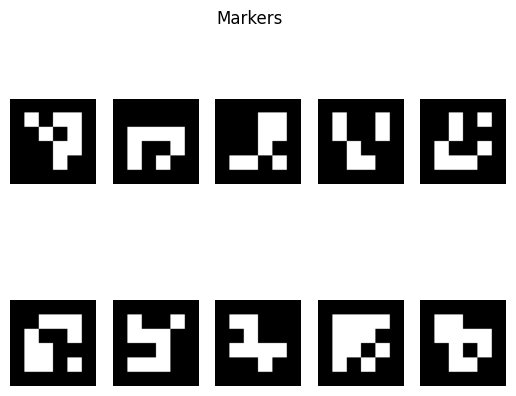

In [6]:
# Generating Unique Markers and placing them in a plt grid
markers = []
for i in range(10):
    markers.append(aruco.generateImageMarker(marker_dict, i, MARKER_SIZE))

fig, ax = plt.subplots(2, 5)
fig.suptitle("Markers")
# grayscale the plt images
for i in range(2):
    for j in range(5):
        ax[i, j].axis('off')
        ax[i, j].imshow(markers[i * 5 + j], cmap='gray')

# save the figure
plt.savefig("markers.png")

In [7]:
from packaging import version

print(cv2.__version__)

4.9.0


In [8]:
# utilizes default camera/webcam driver
cap = cv2.VideoCapture(0)
# iterate through multiple frames, in a live video feed
while True:
    ret, frame = cap.read()
    if not ret:
        break
    # turning the frame to grayscale-only (for efficiency)
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    marker_corners, marker_IDs, reject = detector.detectMarkers(gray_frame)
    # getting conrners of markers
    if marker_corners:
        for ids, corners in zip(marker_IDs, marker_corners):
            cv2.polylines(
                frame, [corners.astype(np.int32)], True, (0, 255, 255), 4, cv2.LINE_AA
            )
            corners = corners.reshape(4, 2)
            corners = corners.astype(int)
            top_right = corners[0].ravel()
            top_left = corners[1].ravel()
            bottom_right = corners[2].ravel()
            bottom_left = corners[3].ravel()
            cv2.putText(
                frame,
                f"id: {ids[0]}",
                top_right,
                cv2.FONT_HERSHEY_PLAIN,
                1.3,
                (200, 100, 0),
                2,
                cv2.LINE_AA,
            )
            print(ids, "  ", corners)
    cv2.imshow("frame", frame)
    key = cv2.waitKey(1)
    if key == ord("q"):
        break
cap.release()
cv2.destroyAllWindows()

# The above code is a simple implementation of detecting aruco markers in a live video feed.   

# now lets try to detect a poolstick

In [16]:
cap.release()

In [15]:
cap = cv2.VideoCapture(0)
FIDUCIAL_TO_STICKEND_RATIO = 4 / 9
while True:
    ret, frame = cap.read()
    if not ret:
        break
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    marker_corners, marker_IDs, reject = detector.detectMarkers(gray_frame)
    if marker_corners:
        back_fiducial_center = None
        front_fiducial_center = None
        for ids, corners in zip(marker_IDs, marker_corners):
            cv2.polylines(
                frame, [corners.astype(np.int32)], True, (0, 255, 255), 4, cv2.LINE_AA
            )
            corners = corners.reshape(4, 2)
            corners = corners.astype(int)
            top_right = corners[0].ravel()
            top_left = corners[1].ravel()
            bottom_right = corners[2].ravel()
            bottom_left = corners[3].ravel()
            cv2.putText(
                frame,
                f"id: {ids[0]}",
                top_right,
                cv2.FONT_HERSHEY_PLAIN,
                1.3,
                (200, 100, 0),
                2,
                cv2.LINE_AA,
            )
            if ids[0] == 8:
                back_fiducial_center = np.mean(corners, axis=0)
            elif ids[0] == 9:
                front_fiducial_center = np.mean(corners, axis=0)
        if back_fiducial_center is not None and front_fiducial_center is not None:
            cv2.line(
                frame,
                tuple(back_fiducial_center.astype(int).ravel()),
                tuple(front_fiducial_center.astype(int).ravel()),
                (0, 255, 0),
                4,
                cv2.LINE_AA,
            )
            stickend = back_fiducial_center * (
                    FIDUCIAL_TO_STICKEND_RATIO + 1) - front_fiducial_center * (FIDUCIAL_TO_STICKEND_RATIO)
            cv2.circle(frame, tuple(stickend.astype(int).ravel()), 10, (0, 0, 255), -1)
        cv2.imshow("frame", frame)
        key = cv2.waitKey(1)
        if key == ord("q"):
            break
cap.release()

KeyboardInterrupt: 

# Lets encapsulate the code into a class

In [26]:
class CuestickDetector:
    def __init__(self, fiducial_to_stickend_ratio=4 / 9):
        self.marker_dict = aruco.getPredefinedDictionary(aruco.DICT_4X4_250)
        self.param_markers = aruco.DetectorParameters()
        self.detector = cv2.aruco.ArucoDetector(self.marker_dict, self.param_markers)
        self.fiducial_to_stickend_ratio = fiducial_to_stickend_ratio

    def detect_cuestick(self, frame):
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        marker_corners, marker_IDs, reject = self.detector.detectMarkers(gray_frame)
        if marker_corners:
            back_fiducial_center = None
            front_fiducial_center = None
            for ids, corners in zip(marker_IDs, marker_corners):
                corners = corners.reshape(4, 2)
                corners = corners.astype(int)
                if ids[0] == 8:
                    back_fiducial_center = np.mean(corners, axis=0)
                elif ids[0] == 9:
                    front_fiducial_center = np.mean(corners, axis=0)
            if back_fiducial_center is not None and front_fiducial_center is not None:
                stickend = back_fiducial_center * (
                        self.fiducial_to_stickend_ratio + 1) - front_fiducial_center * self.fiducial_to_stickend_ratio
                return stickend, back_fiducial_center, front_fiducial_center
        return None
    
    def draw_cuestick(self, frame, stickend, back_fiducial_center, front_fiducial_center):
        cv2.line(
            frame,
            tuple(back_fiducial_center.astype(int).ravel()),
            tuple(front_fiducial_center.astype(int).ravel()),
            (0, 255, 0),
            4,
            cv2.LINE_AA,
        )
        
        cv2.circle(frame, tuple(stickend.astype(int).ravel()), 10, (0, 0, 255), -1)
        
        vector = back_fiducial_center - front_fiducial_center
        vector = vector / np.linalg.norm(vector)
        cv2.arrowedLine(
            frame,
            tuple(stickend.astype(int).ravel()),
            tuple((stickend + vector * 50).astype(int).ravel()),
            (255, 0, 0),
            4,
            cv2.LINE_AA,
        )
        return frame
        

In [27]:
Detector = CuestickDetector()
cap = cv2.VideoCapture(0)
while True:
    ret, frame = cap.read()
    if not ret:
        break
    cuestick = Detector.detect_cuestick(frame)
    if cuestick is not None:
        stickend, back_fiducial_center, front_fiducial_center = cuestick
        frame = Detector.draw_cuestick(frame, stickend, back_fiducial_center, front_fiducial_center)
    cv2.imshow("frame", frame)
    key = cv2.waitKey(1)
    if key == ord("q"):
        break
cap.release()
cv2.destroyAllWindows()

In [34]:
n = 21
l = [i for i in range(1,n-1) if n / i == n // i]
m = l[len(l)//2]
print(n, m, n/m)

21 3 7.0
